In [1]:
""" Plot the output of a random network to visualize
    smoothness as done in Ramachandran et al. 2017 to gain
    intuition about different e-swish variants. 
"""

# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K 
import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Optimizer
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.callbacks import TensorBoard, EarlyStopping

Using TensorFlow backend.


In [2]:
# Different activations to test<

# Swish activation function
# x*sigmoid(x)
def swish(x):
    return x*K.sigmoid(x)

# Custom activation function 1
# mix between relu and positive part of swish mirrored across x=1
def e_swish_1(x):
    return K.maximum(0.0, x*(2-K.sigmoid(x)))

# Custom activation function 2
# positive part of swish mirrored across x=1
def e_swish_2(x):
    return K.maximum(x*K.sigmoid(x), x*(2-K.sigmoid(x)))

# Custom activation function 3 - Hand designed
# e_swish_2 made derivable
def e_swish_3(x):
    return K.maximum(8*K.sigmoid(x)*(1-K.sigmoid(x))*x*K.sigmoid(x), x*(2-K.sigmoid(x)))

# Custom activation function 4 - Reduced operations for e_swish_3 
# e_swish_2 made derivable (more similar to swish in the negative part)
def e_swish_4(x):
    return K.maximum((1+0.25/(K.exp(K.abs(x))-0.75))*x*K.sigmoid(x), x*(2-K.sigmoid(x)))

def leaky_relu(x):
    return K.maximum(0.3*x,x)

In [3]:
a, res= 200, 1 # Area and resolution
x = np.array([[(i)/res, (j)/res] for i in range(-a, +a) for j in range(-a, +a)])
print(x.shape)

(160000, 2)


In [4]:
def create_model(act, l):
    np.random.seed(42)
    tf.set_random_seed(42)
    # with tf.device('/cpu:0'): # Makes it more deterministic (CuDNN indetermination)
    model = Sequential()
    model.add(Dense(128, activation=act, input_dim=2))
    for i in range(l):
        model.add(Dense(128, activation=act, kernel_initializer='random_normal', bias_initializer='zeros'))
    model.add(Dense(1, activation=act))

    model.compile(loss='categorical_crossentropy', optimizer='adamax', metrics=['accuracy'])
    return model

In [5]:
activations = [e_swish_1, e_swish_2, e_swish_3,  e_swish_4, swish, "relu", leaky_relu, "linear", "tanh"]
names = activations[:]
for i,act in enumerate(names):
    if not isinstance(act, str):
        names[i] = act.__name__
print(names)

['e_swish_1', 'e_swish_2', 'e_swish_3', 'e_swish_4', 'swish', 'relu', 'leaky_relu', 'linear', 'tanh']


<IPython.core.display.Javascript object>


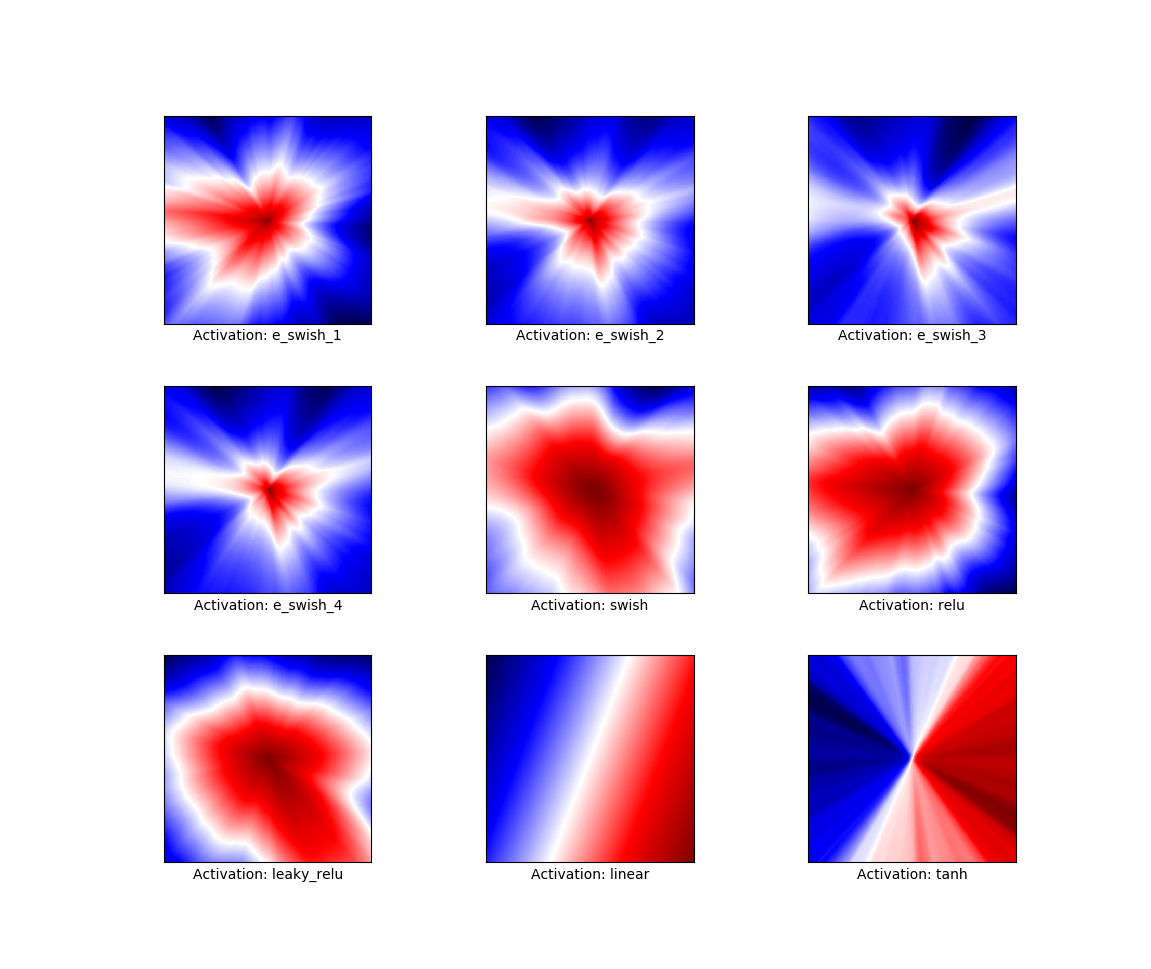

In [7]:
%matplotlib notebook
def show(activations, names):
 # Create a 3*3 figure to display images.
    fig, axes = plt.subplots(3,3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        try:
            # Create the model
            act, act_name = activations[i], names[i]
            model = create_model(act,5)
            pred = model.predict(x)
            # Print image.
            ax.imshow(pred.reshape(2*a,2*a), cmap="seismic_r")
            # Set labels
            xlabel = "Activation: {}".format(act_name)
            ax.set_xlabel(xlabel)
        except: pass
        # Remove x and y axis.
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

show(activations, names)